# Imports

In [37]:
import os
import sys
import pickle
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))

from SRModels.constants import *
from SRModels.loading_methods import load_predictions_dataset
from SRModels.deep_learning_models.SRCNN_model import SRCNNModel
from SRModels.deep_learning_models.EDSR_model import EDSR
from SRModels.deep_learning_models.ESRGAN_model import ESRGAN
from SRModels.defect_detection_models.VGG16_model import FineTunedVGG16
from SRModels.deep_lerning_visualizations import *

# CONSTANTS

In [24]:
SRCNN_PRETRAINED_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/SRCNN/SRCNN_20250909_205417/SRCNN_20250909_205417.h5"))
SRCNN_HR_DIMENSIONS_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/SRCNN/SRCNN_20250909_205417/SRCNN_20250909_205417_hrh_hrw.pkl"))
SRCNN_TRAIN_METRICS_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/SRCNN/SRCNN_20250909_205417/SRCNN_20250909_205417_metrics.pkl"))

EDSR_PRETRAINED_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/EDSR/EDSR_20250909_205911/EDSR_x2_20250909_205911.h5"))
EDSR_TRAIN_METRICS_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/EDSR/EDSR_20250909_205911/EDSR_20250909_205911_metrics.pkl"))

ESRGAN_GENERATOR_PRETRAINED_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/ESRGAN/ESRGAN_20250909_193854/ESRGAN_generator_x2_20250909_193854.h5"))
ESRGAN_DISCRIMINATOR_PRETRAINED_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/ESRGAN/ESRGAN_20250909_193854/ESRGAN_discriminator_x2_20250909_193854.h5"))
ESRGAN_TRAIN_METRICS_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/ESRGAN/ESRGAN_20250909_193854/ESRGAN_20250909_193854_metrics.pkl"))

VGG16_PRETRAINED_PATH = os.path.abspath(os.path.join(os.getcwd(), "defect_detection_models/models/VGG16/VGG16_20250909_204806/VGG16_20250909_204806.h5"))
VGG16_TRAIN_METRICS_PATH = os.path.abspath(os.path.join(os.getcwd(), "defect_detection_models/models/VGG16/VGG16_20250909_204806/VGG16_20250909_204806_metrics.pkl"))

# LR Dataset loading

In [3]:
# Paths to LR images and labels map generated by preprocessing_functions
LR_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../data/images_for_predictions/LR"))
CLASS_LABELS_PATH = os.path.abspath(os.path.join(os.getcwd(), "../data/images_for_predictions/predictions_class_labels_map.pkl"))

# Load arrays
X, y = load_predictions_dataset(LR_ROOT, CLASS_LABELS_PATH)
print(f"Loaded LR images: {X.shape} | Labels: {y.shape}")

Loaded LR images: (113, 239, 239, 3) | Labels: (113,)


# SRCNN model predictions

In [4]:
# Load HR dimensions
with open(SRCNN_HR_DIMENSIONS_PATH, "rb") as f:
    hr_h, hr_w = pickle.load(f)

# Load pretrained SRCNN model
pretrained_srcnn_model = SRCNNModel()

pretrained_srcnn_model.setup_model(from_pretrained=True, pretrained_path=SRCNN_PRETRAINED_PATH)

Loaded pretrained model from c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\SRCNN\SRCNN_20250909_205417\SRCNN_20250909_205417.h5


In [5]:
# Super-resolve all LR images with SRCNN (using X)
srcnn_sr_images = []
srcnn_times = []
srcnn_mean_gpus = []
srcnn_peak_gpus = []

for idx in tqdm(range(X.shape[0]), total=X.shape[0], desc="SRCNN inference"):
    sr_img, metrics = pretrained_srcnn_model.super_resolve_image(X[idx], hr_h=hr_h, hr_w=hr_w, patch_size=SRCNN_PATCH_SIZE, stride=SRCNN_STRIDE)
    srcnn_sr_images.append(sr_img)
    srcnn_times.append(metrics["time_sec"])
    srcnn_mean_gpus.append(metrics["gpu_mean_current_mb"])
    srcnn_peak_gpus.append(metrics["gpu_peak_mb"])
    
srcnn_sr_images = np.stack(srcnn_sr_images, axis=0)
srcnn_time_mean = np.mean(srcnn_times)
srcnn_gpu_mean_mean = np.mean(srcnn_mean_gpus)
srcnn_gpu_peak_max = np.max(srcnn_peak_gpus)

print(f"SRCNN: mean_time={srcnn_time_mean:.4f}s, mean_gpu={srcnn_gpu_mean_mean:.2f}MB, peak_gpu={srcnn_gpu_peak_max:.2f}MB")

SRCNN inference: 100%|██████████| 113/113 [00:24<00:00,  4.68it/s]

SRCNN: mean_time=0.1881s, mean_gpu=77.59MB, peak_gpu=177.78MB


# EDSR model predictions

In [8]:
# Load pretrained EDSR model
pretrained_edsr_model = EDSR()

pretrained_edsr_model.setup_model(scale_factor=EDSR_SCALE_FACTOR, from_pretrained=True, pretrained_path=EDSR_PRETRAINED_PATH)

Loaded pretrained model from c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\EDSR\EDSR_20250909_205911\EDSR_x2_20250909_205911.h5


In [9]:
# Super-resolve all LR images with EDSR (using X)
edsr_sr_list = []
edsr_times = []
edsr_mean_gpus = []
edsr_peak_gpus = []

for idx, lr_img in enumerate(tqdm(X, total=X.shape[0], desc="EDSR inference")):
    sr_img, metrics = pretrained_edsr_model.super_resolve_image(lr_img, patch_size_lr=EDSR_PATCH_SIZE, stride=EDSR_STRIDE)
    edsr_sr_list.append(sr_img)
    edsr_times.append(metrics["time_sec"])
    edsr_mean_gpus.append(metrics["gpu_mean_current_mb"])
    edsr_peak_gpus.append(metrics["gpu_peak_mb"])
    
edsr_sr_images = np.stack(edsr_sr_list, axis=0)
edsr_time_mean = np.mean(edsr_times)
edsr_gpu_mean_mean = np.mean(edsr_mean_gpus)
edsr_gpu_peak_max = np.max(edsr_peak_gpus)

print(f"EDSR: mean_time={edsr_time_mean:.4f}s, mean_gpu={edsr_gpu_mean_mean:.2f}MB, peak_gpu={edsr_gpu_peak_max:.2f}MB")

EDSR inference: 100%|██████████| 113/113 [00:25<00:00,  4.41it/s]

EDSR: mean_time=0.2145s, mean_gpu=112.00MB, peak_gpu=177.78MB


# ESRGAN model predictions

In [10]:
# Load pretrained ESRGAN model
pretrained_esrgan_model = ESRGAN()

pretrained_esrgan_model.setup_model(
    from_trained=True, 
    generator_pretrained_path=ESRGAN_GENERATOR_PRETRAINED_PATH, 
    discriminator_pretrained_path=ESRGAN_DISCRIMINATOR_PRETRAINED_PATH
)

- Generator loaded from: c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\ESRGAN\ESRGAN_20250909_193854\ESRGAN_generator_x2_20250909_193854.h5
- Discriminator loaded from: c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\ESRGAN\ESRGAN_20250909_193854\ESRGAN_discriminator_x2_20250909_193854.h5
- VGG model built for perceptual loss


In [11]:
# Super-resolve all LR images with ESRGAN (using X)
esrgan_sr_list = []
esrgan_times = []
esrgan_mean_gpus = []
esrgan_peak_gpus = []

for idx, lr_img in enumerate(tqdm(X, total=X.shape[0], desc="ESRGAN inference")):
    sr_img, metrics = pretrained_esrgan_model.super_resolve_image(lr_img, patch_size_lr=ESRGAN_PATCH_SIZE, stride=ESRGAN_STRIDE, batch_size=8)
    esrgan_sr_list.append(sr_img)
    esrgan_times.append(metrics["time_sec"])
    esrgan_mean_gpus.append(metrics["gpu_mean_current_mb"])
    esrgan_peak_gpus.append(metrics["gpu_peak_mb"])
    
esrgan_sr_images = np.stack(esrgan_sr_list, axis=0)
esrgan_time_mean = np.mean(esrgan_times)
esrgan_gpu_mean_mean = np.mean(esrgan_mean_gpus)
esrgan_gpu_peak_max = np.max(esrgan_peak_gpus)

print(f"ESRGAN: mean_time={esrgan_time_mean:.4f}s, mean_gpu={esrgan_gpu_mean_mean:.2f}MB, peak_gpu={esrgan_gpu_peak_max:.2f}MB")

ESRGAN inference: 100%|██████████| 113/113 [01:06<00:00,  1.70it/s]

ESRGAN: mean_time=0.5672s, mean_gpu=149.60MB, peak_gpu=674.80MB


# VGG16 model predictions

In [14]:
# Load pretrained VGG16 model for feature extraction
pretrained_vgg16_model = FineTunedVGG16()

pretrained_vgg16_model.setup_model(from_pretrained=True, pretrained_path=VGG16_PRETRAINED_PATH)

Loaded pretrained model from c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\defect_detection_models\models\VGG16\VGG16_20250909_204806\VGG16_20250909_204806.h5


In [15]:
# Classify LR images with VGG16 majority voting
lr_labels = []
lr_confidences = []

for idx, img in enumerate(tqdm(X, total=X.shape[0], desc="VGG16 on LR")):
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
    )
    lr_labels.append(int(label))
    lr_confidences.append(float(conf))

print(f"LR classified: {len(lr_labels)} images")

VGG16 on LR: 100%|██████████| 113/113 [00:06<00:00, 18.39it/s]

LR classified: 113 images


In [16]:
# Classify SRCNN SR images with VGG16 majority voting
srcnn_labels = []
srcnn_confidences = []

for idx, img in enumerate(tqdm(srcnn_sr_images, total=srcnn_sr_images.shape[0], desc="VGG16 on SRCNN")):
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
    )
    srcnn_labels.append(int(label))
    srcnn_confidences.append(float(conf))

print(f"SRCNN classified: {len(srcnn_labels)} images")

VGG16 on SRCNN: 100%|██████████| 113/113 [00:12<00:00,  9.21it/s]

SRCNN classified: 113 images


In [17]:
# Classify EDSR SR images with VGG16 majority voting
edsr_labels = []
edsr_confidences = []

for idx, img in enumerate(tqdm(edsr_sr_images, total=edsr_sr_images.shape[0], desc="VGG16 on EDSR")):
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
    )
    edsr_labels.append(int(label))
    edsr_confidences.append(float(conf))

print(f"EDSR classified: {len(edsr_labels)} images")

VGG16 on EDSR: 100%|██████████| 113/113 [00:09<00:00, 11.57it/s]

EDSR classified: 113 images


In [18]:
# Classify ESRGAN SR images with VGG16 majority voting
esrgan_labels = []
esrgan_confidences = []

for idx, img in enumerate(tqdm(esrgan_sr_images, total=esrgan_sr_images.shape[0], desc="VGG16 on ESRGAN")):
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
    )
    esrgan_labels.append(int(label))
    esrgan_confidences.append(float(conf))

print(f"ESRGAN classified: {len(esrgan_labels)} images")

VGG16 on ESRGAN: 100%|██████████| 113/113 [00:09<00:00, 12.13it/s]

ESRGAN classified: 113 images


# Deep learning metrics

In [25]:
# Load training metrics
with open(SRCNN_TRAIN_METRICS_PATH, "rb") as f:
    srcnn_train_metrics = pickle.load(f)
with open(EDSR_TRAIN_METRICS_PATH, "rb") as f:
    edsr_train_metrics = pickle.load(f)
with open(ESRGAN_TRAIN_METRICS_PATH, "rb") as f:
    esrgan_train_metrics = pickle.load(f)
with open(VGG16_TRAIN_METRICS_PATH, "rb") as f:
    vgg16_train_metrics = pickle.load(f)

(<Figure size 1400x1000 with 9 Axes>,
 array([[<Axes: title={'center': 'Train Loss'}, ylabel='Loss'>,
         <Axes: title={'center': 'Train PSNR'}, ylabel='dB'>,
         <Axes: title={'center': 'Train SSIM'}>],
        [<Axes: title={'center': 'Val Loss'}, ylabel='Loss'>,
         <Axes: title={'center': 'Val PSNR'}, ylabel='dB'>,
         <Axes: title={'center': 'Val SSIM'}>],
        [<Axes: title={'center': 'Eval Loss'}, ylabel='Loss'>,
         <Axes: title={'center': 'Eval PSNR'}, ylabel='dB'>,
         <Axes: title={'center': 'Eval SSIM'}>]], dtype=object))

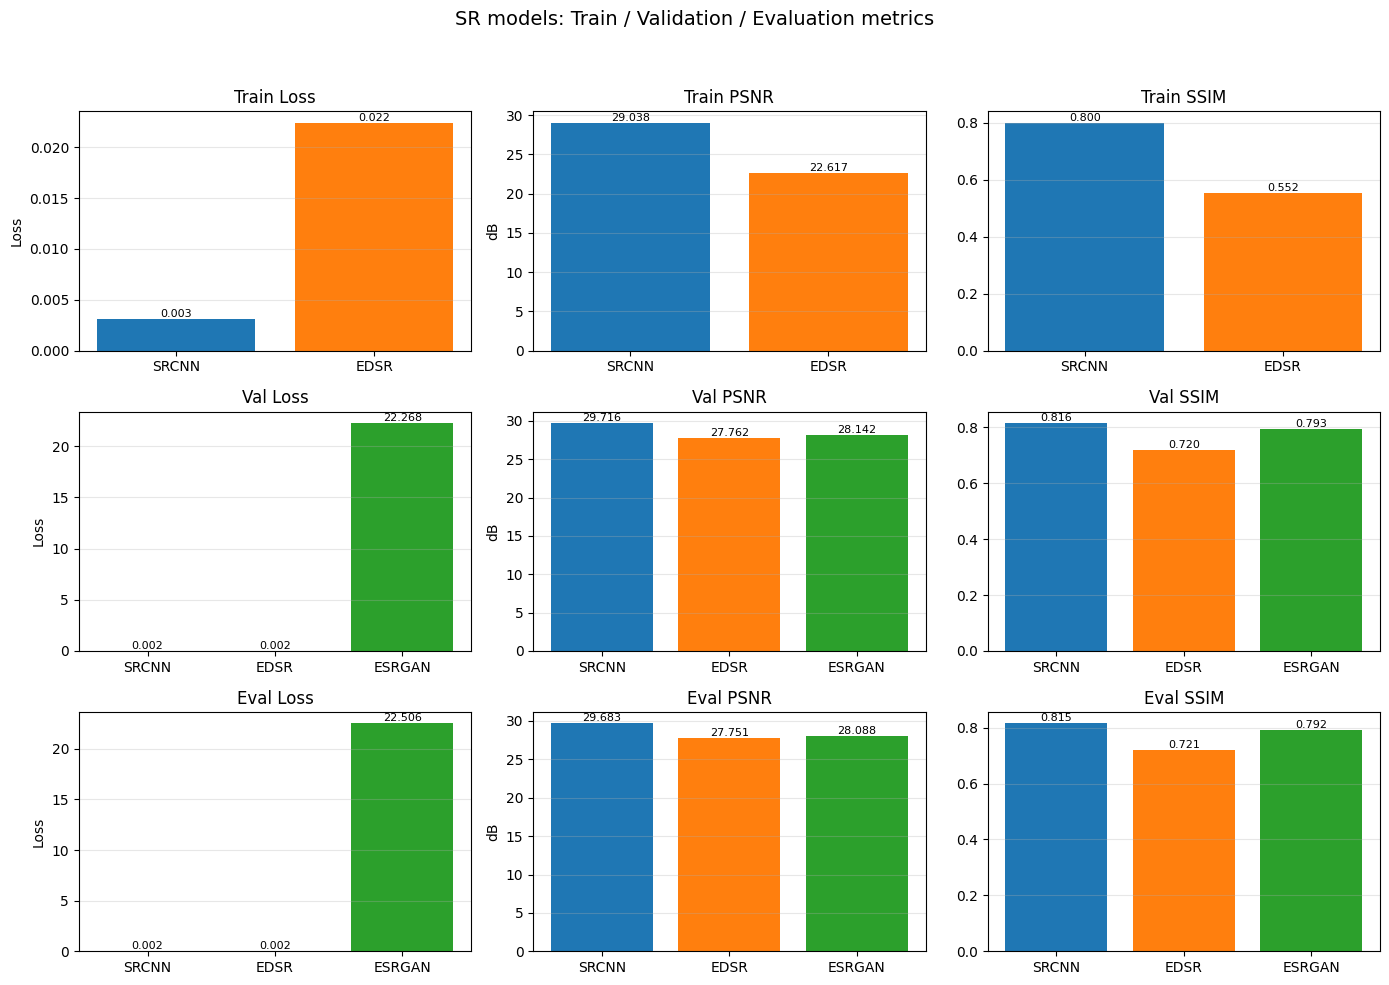

In [44]:
plot_sr_metrics(srcnn_train_metrics, edsr_train_metrics, esrgan_train_metrics, save_path="DL_results")

(<Figure size 1200x400 with 2 Axes>,
 array([<Axes: title={'center': 'Tiempo entrenamiento (s)'}, ylabel='Segundos'>,
        <Axes: title={'center': 'Tiempo evaluación (s)'}, ylabel='Segundos'>],
       dtype=object))

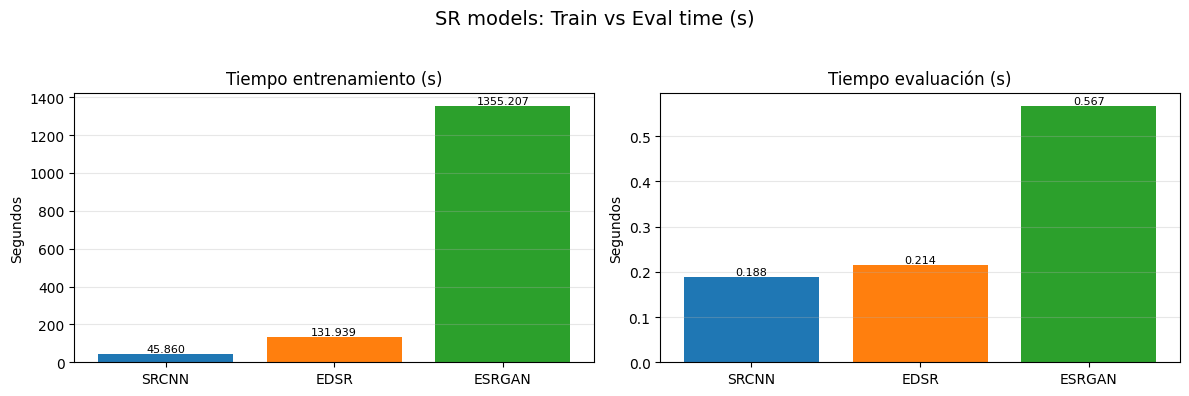

In [34]:
# Time panel
plot_sr_time(
    srcnn_train_metrics,
    edsr_train_metrics,
    esrgan_train_metrics,
    srcnn_time_mean,
    edsr_time_mean,
    esrgan_time_mean,
    save_path="DL_results",
)

(<Figure size 1400x800 with 4 Axes>,
 array([[<Axes: title={'center': 'Entrenamiento (media)'}, ylabel='MB'>,
         <Axes: title={'center': 'Entrenamiento (pico)'}, ylabel='MB'>],
        [<Axes: title={'center': 'Evaluación (media)'}, ylabel='MB'>,
         <Axes: title={'center': 'Evaluación (pico)'}, ylabel='MB'>]],
       dtype=object))

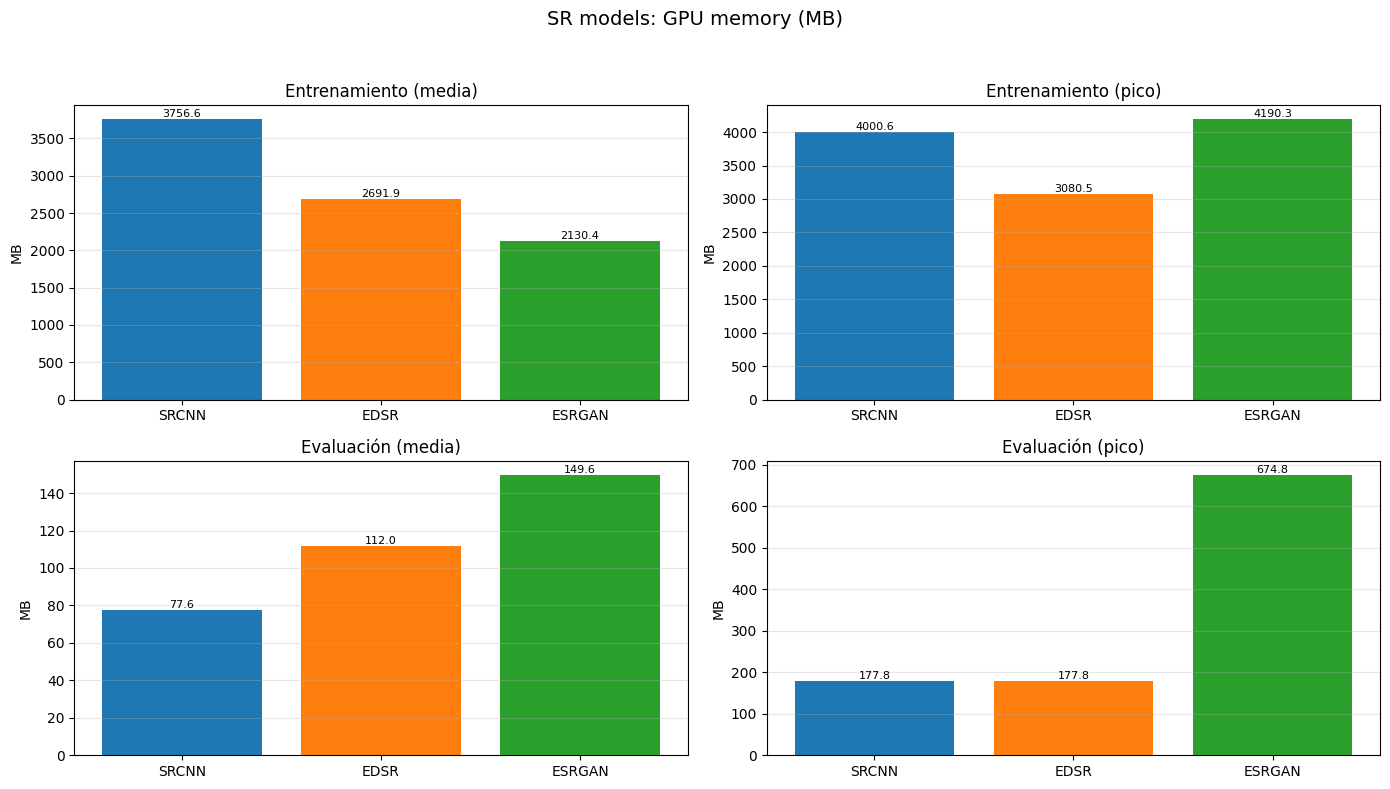

In [43]:
# Memory panel
plot_sr_memory(
    srcnn_train_metrics,
    edsr_train_metrics,
    esrgan_train_metrics,
    srcnn_gpu_mean_mean,
    edsr_gpu_mean_mean,
    esrgan_gpu_mean_mean,
    srcnn_gpu_peak_max,
    edsr_gpu_peak_max,
    esrgan_gpu_peak_max,
    save_path="DL_results",
)

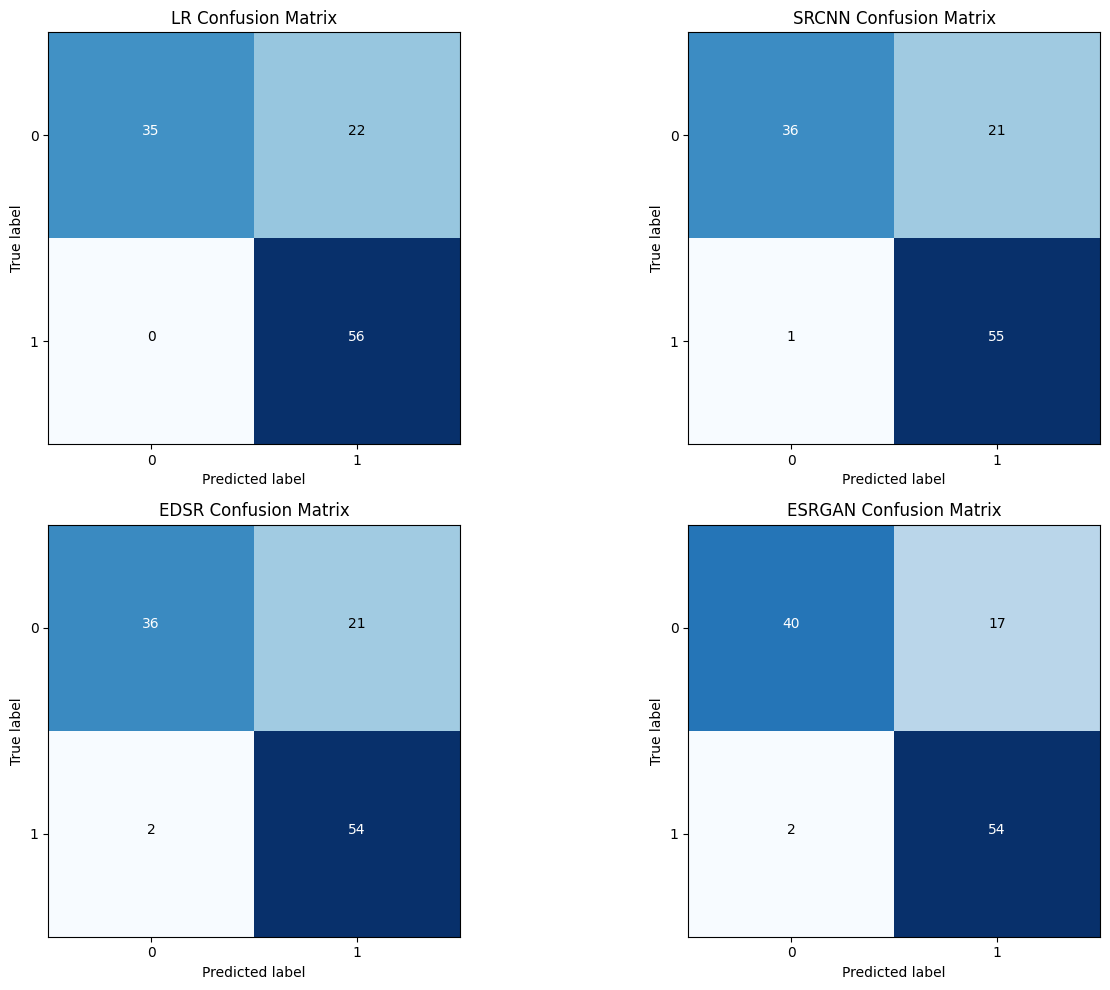

In [19]:
class_names = [str(c) for c in sorted(np.unique(y))] if 'y' in globals() else ['0','1']

# Build confusion matrices safely
cm_lr = confusion_matrix(y, lr_labels) if 'lr_labels' in globals() else np.zeros((len(class_names), len(class_names)), dtype=int)
cm_srcnn = confusion_matrix(y, srcnn_labels) if 'srcnn_labels' in globals() else np.zeros_like(cm_lr)
cm_edsr = confusion_matrix(y, edsr_labels) if 'edsr_labels' in globals() else np.zeros_like(cm_lr)
cm_esrgan = confusion_matrix(y, esrgan_labels) if 'esrgan_labels' in globals() else np.zeros_like(cm_lr)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

plot_confusion(axes[0], cm_lr, class_names, title='LR Confusion Matrix')
plot_confusion(axes[1], cm_srcnn, class_names, title='SRCNN Confusion Matrix')
plot_confusion(axes[2], cm_edsr, class_names, title='EDSR Confusion Matrix')
plot_confusion(axes[3], cm_esrgan, class_names, title='ESRGAN Confusion Matrix')

plt.tight_layout()
plt.show()

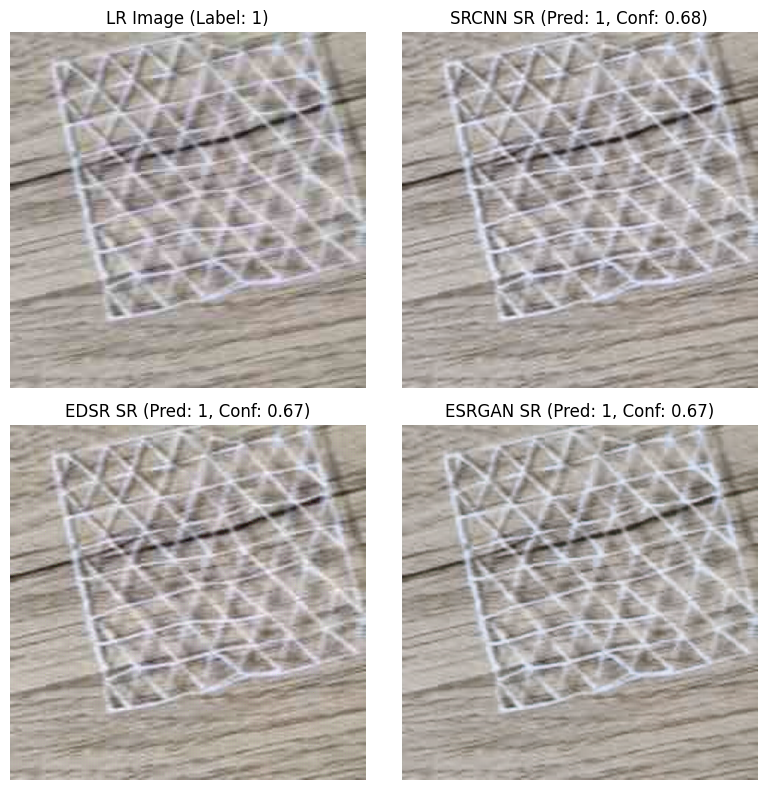

In [ ]:
plot_2x2(
    images=[
        X[0],
        srcnn_sr_images[0],
        edsr_sr_images[0],
        esrgan_sr_images[0]
    ],
    titles=[
        f"LR Image (Label: {y[0]})",
        f"SRCNN SR (Pred: {srcnn_labels[0]}, Conf: {srcnn_confidences[0]:.2f})",
        f"EDSR SR (Pred: {edsr_labels[0]}, Conf: {edsr_confidences[0]:.2f})",
        f"ESRGAN SR (Pred: {esrgan_labels[0]}, Conf: {esrgan_confidences[0]:.2f})"
    ]
)

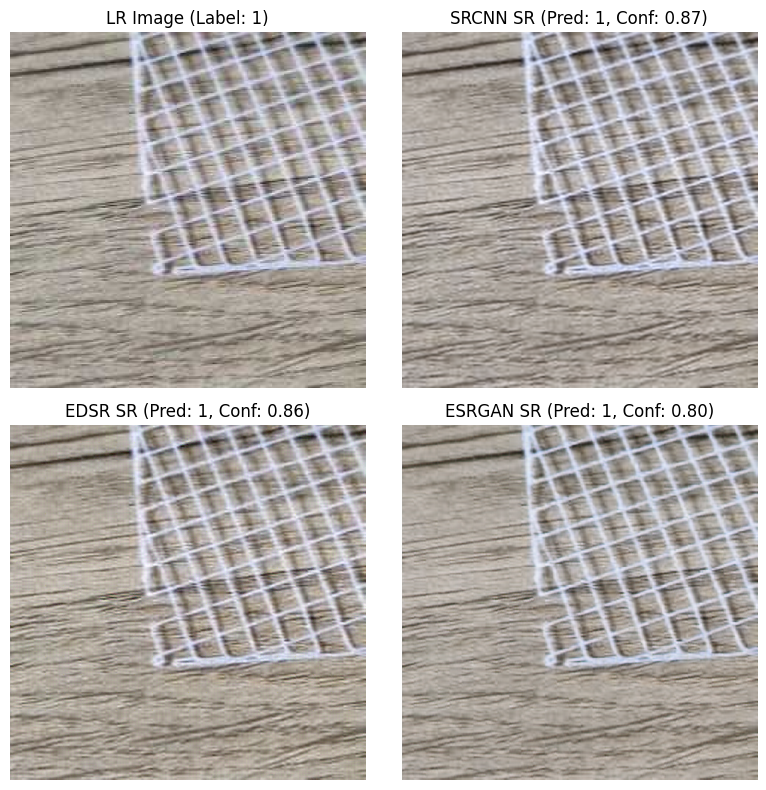

In [41]:
plot_2x2(
    images=[
        X[20],
        srcnn_sr_images[20],
        edsr_sr_images[20],
        esrgan_sr_images[20]
    ],
    titles=[
        f"LR Image (Label: {y[20]})",
        f"SRCNN SR (Pred: {srcnn_labels[20]}, Conf: {srcnn_confidences[20]:.2f})",
        f"EDSR SR (Pred: {edsr_labels[20]}, Conf: {edsr_confidences[20]:.2f})",
        f"ESRGAN SR (Pred: {esrgan_labels[20]}, Conf: {esrgan_confidences[20]:.2f})"
    ]
)

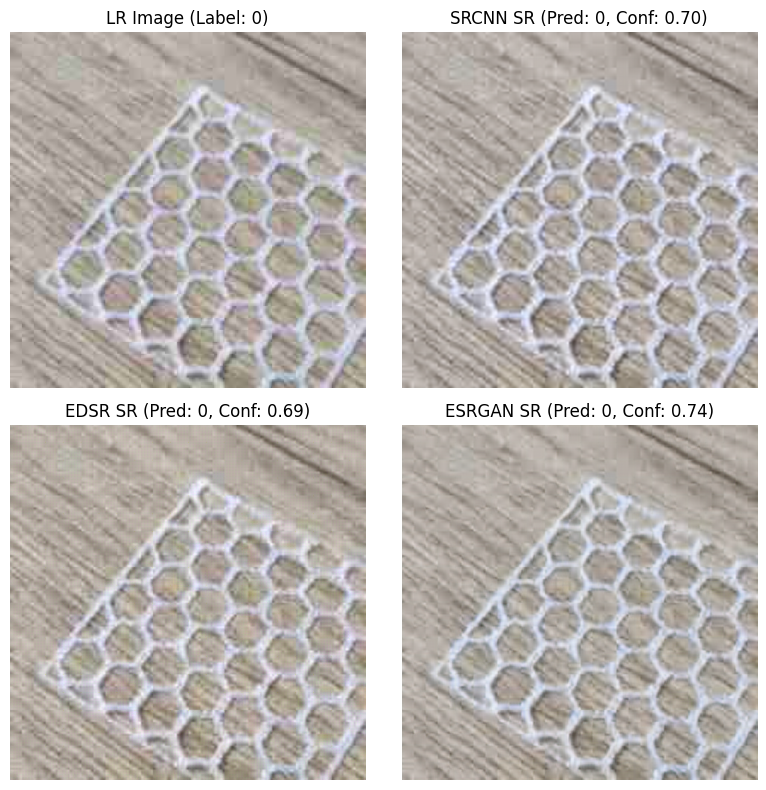

In [42]:
plot_2x2(
    images=[
        X[80],
        srcnn_sr_images[80],
        edsr_sr_images[80],
        esrgan_sr_images[80]
    ],
    titles=[
        f"LR Image (Label: {y[80]})",
        f"SRCNN SR (Pred: {srcnn_labels[80]}, Conf: {srcnn_confidences[80]:.2f})",
        f"EDSR SR (Pred: {edsr_labels[80]}, Conf: {edsr_confidences[80]:.2f})",
        f"ESRGAN SR (Pred: {esrgan_labels[80]}, Conf: {esrgan_confidences[80]:.2f})"
    ]
)